# Description:

    Investigate OTU abundances



# Setting variables

# Init

In [2]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R
workDir = '/home/bryan/ERA/data/figures/'
setwd(workDir)

In [6]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

# Load phyloseq object

In [7]:
%%R 
physeq = readRDS(file = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds')
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [8]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

# Taxa distribution

## Rank Abundance

In [9]:
%%R
getwd()

[1] "/home/bryan/ERA/data/figures"


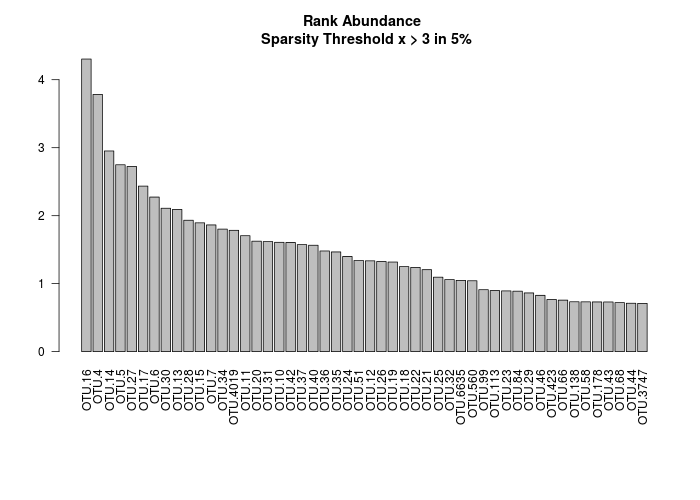

In [13]:
%%R -w 700 -h 500
par(mar = c(10, 4, 4, 2) + 0.1) # make more room on bottom margin
N <- 50

#print to file
pdf(file = "RankAbundance.pdf")
barplot(sort(taxa_sums(physeq), TRUE)[1:N], las=2, 
        main = "Rank Abundance \n Sparsity Threshold x > 3 in 5%")
dev.off()

#print to screen
barplot(sort(taxa_sums(physeq), TRUE)[1:N], las=2, 
        main = "Rank Abundance \n Sparsity Threshold x > 3 in 5%")

## Generate abundance bar plots for each sample

In [14]:
%%R
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [16]:
%%R
s.df = sample_data(physeq)
s.df.o =  s.df[with(s.df, order(TimePoint, Plant, Fert))]
head(s.df.o) %>% print
samples = sample_names(s.df.o)

                 X.sampleID  TubeID ExtractionPlate PooledDNAPlate
ERA-T0_1-5a_0 ERA-T0_1-5a_0 BD - 25            ERA3              C
ERA-T0_4-3d_0 ERA-T0_4-3d_0 BD - 16            ERA3              C
ERA-T0_2-3b_0 ERA-T0_2-3b_0 BD - 19            ERA3              C
ERA-T0_3-2c_0 ERA-T0_3-2c_0 BD - 12            ERA3              C
ERA-T0_2-2c_0 ERA-T0_2-2c_0 BD - 26            ERA3              C
ERA-T0_3-4c_0 ERA-T0_3-4c_0  BD - 7            ERA3              C
              Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X
ERA-T0_1-5a_0             C6           3            22             F3 NA
ERA-T0_4-3d_0             D9           3            47             G6 NA
ERA-T0_2-3b_0             H5           3            20             D3 NA
ERA-T0_3-2c_0             B9           3            45             E6 NA
ERA-T0_2-2c_0             B7           3            29             E4 NA
ERA-T0_3-4c_0             C9           3            46             F6 NA
              primer

In [19]:
%%R
Title = paste(s.df.o$TimePoint, s.df.o$Plant, s.df.o$Fert, sep = "-")
Title

  [1] "T0-Bare-0"      "T0-Bare-0"      "T0-Bare-0"      "T0-Bare-0"     
  [5] "T0-P1151HR-0"   "T0-P1151HR-0"   "T0-P1151HR-0"   "T1-330-0"      
  [9] "T1-330-0"       "T1-330-0"       "T1-330-0"       "T1-330-85"     
 [13] "T1-330-85"      "T1-330-85"      "T1-330-85"      "T1-330-170"    
 [17] "T1-330-170"     "T1-330-170"     "T1-330-170"     "T1-3475-0"     
 [21] "T1-3475-0"      "T1-3475-0"      "T1-3475-0"      "T1-3475-85"    
 [25] "T1-3475-85"     "T1-3475-85"     "T1-3475-85"     "T1-3475-170"   
 [29] "T1-3475-170"    "T1-3475-170"    "T1-3475-170"    "T1-34M95-0"    
 [33] "T1-34M95-0"     "T1-34M95-0"     "T1-34M95-0"     "T1-34M95-85"   
 [37] "T1-34M95-85"    "T1-34M95-85"    "T1-34M95-85"    "T1-34M95-170"  
 [41] "T1-34M95-170"   "T1-34M95-170"   "T1-34M95-170"   "T1-3517-0"     
 [45] "T1-3517-0"      "T1-3517-0"      "T1-3517-0"      "T1-3517-85"    
 [49] "T1-3517-85"     "T1-3517-85"     "T1-3517-85"     "T1-3517-170"   
 [53] "T1-3517-170"    "T1-3517-170"  

# Explore OTU relative abundance

In [20]:
%%R 

pdf("sample_rel-abundance.pdf", onefile = TRUE)

N = nsamples(physeq)

s.df = sample_data(physeq)
s.df.o =  s.df[with(s.df, order(TimePoint, Plant, Fert))]
samples = sample_names(s.df.o)
Title = paste(s.df.o$TimePoint, s.df.o$Plant, s.df.o$Fert, sep = "-")

for(i in 1:N){
    samplename = samples[i]
    sample = subset_samples(physeq, X.sampleID == samplename)
  

    TopOTUs = names(sort(taxa_sums(sample), TRUE)[1:50])
    Top = prune_taxa(TopOTUs, sample)
    #title = paste(sample_data(Top)$Plant, samplename, sample_sums(Top), sep = " ")
    plot =  barplot(sort(taxa_sums(Top), TRUE), las=2, 
        main = Title[i])
    plot
}

dev.off()



png 
  2 
